In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [4]:
# Load the data
df = pd.read_csv('processed_odds_data.csv')

In [5]:
# Convert to datetime and extract features
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.sort_values('datetime').reset_index(drop=True)

In [6]:
# Create time-based features
df['time_since_start'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds()
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df['time_of_day'] = df['hour'] + df['minute']/60 + df['second']/3600

In [7]:
# Create lag features
for lag in [1, 2, 3, 5, 10]:
    df[f'lag_{lag}'] = df['ODDs'].shift(lag)

In [8]:
# Create rolling statistics
df['rolling_mean_5'] = df['ODDs'].rolling(5).mean()
df['rolling_std_5'] = df['ODDs'].rolling(5).std()
df['rolling_max_5'] = df['ODDs'].rolling(5).max()

In [9]:
# Drop rows with NaN values from feature creation
df = df.dropna()

In [10]:
# Split data into features and target
X = df.drop(['ODDs', 'Date', 'Time', 'datetime'], axis=1)
y = df['ODDs']

In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    return {
        'model': model.__class__.__name__,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'predictions': preds
    }

In [14]:
# Try different models
models = [
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    XGBRegressor(n_estimators=100, random_state=42),
    # ARIMA(order=(5,1,0))  # Will handle separately - This line was causing the error
    # Instead, we'll initialize it later with the data:
    'ARIMA'  # Placeholder, will initialize with data before fitting
]

In [15]:
# Evaluate non-ARIMA models
results = []
for model in models[:-1]:
    results.append(evaluate_model(model, X_train, X_test, y_train, y_test))

In [ ]:
"""# Evaluate ARIMA separately (time series specific)
arima_model = ARIMA(y_train, order=(5,1,0))
arima_fit = arima_model.fit()
arima_preds = arima_fit.forecast(steps=len(y_test))

results.append({
    'model': 'ARIMA',
    'mse': mean_squared_error(y_test, arima_preds),
    'mae': mean_absolute_error(y_test, arima_preds),
    'r2': r2_score(y_test, arima_preds),
    'predictions': arima_preds
})
"""

In [16]:
# Evaluate ARIMA separately (time series specific)
arima_model = ARIMA(y_train, order=(5,1,0)) # Now we're providing the 'endog' (y_train)
arima_fit = arima_model.fit()
arima_preds = arima_fit.forecast(steps=len(y_test))

results.append({
    'model': 'ARIMA',
    'mse': mean_squared_error(y_test, arima_preds),
    'mae': mean_absolute_error(y_test, arima_preds),
    'r2': r2_score(y_test, arima_preds),
    'predictions': arima_preds
})

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

In [17]:
# Find best model based on MSE
best_model_result = min(results, key=lambda x: x['mse'])
print(f"Best model: {best_model_result['model']}")
print(f"MSE: {best_model_result['mse']:.4f}")
print(f"MAE: {best_model_result['mae']:.4f}")
print(f"R2: {best_model_result['r2']:.4f}")

Best model: GradientBoostingRegressor
MSE: 9722.5364
MAE: 10.3670
R2: 0.4162


In [19]:
# Retrain best model on full data
if best_model_result['model'] != 'ARIMA':
    best_model = [m for m in models if m.__class__.__name__ == best_model_result['model']][0]
    best_model.fit(X, y)

    # Make predictions (next 10 odds)
    last_features = X.iloc[-1:].copy()
    predictions = []

    for _ in range(10):
        # Update lag features for next prediction
        pred = best_model.predict(last_features)[0]
        predictions.append(pred)

        # Shift lags for next prediction
        # Change: Use only the defined lags
        for lag in [1, 2, 3, 5, 10]:
            if lag == 1:
                last_features[f'lag_{lag}'] = pred
            # Change: Check if the previous lag exists to avoid KeyError
            elif f'lag_{lag-1}' in last_features.columns:
                last_features[f'lag_{lag}'] = last_features[f'lag_{lag-1}'].values[0]

        # Update rolling stats (simplified approach)
        last_features['rolling_mean_5'] = (last_features['lag_1'] + last_features['lag_2'] +
                                         last_features['lag_3'] + last_features['lag_5'])/4
        # Can add more sophisticated rolling stat updates

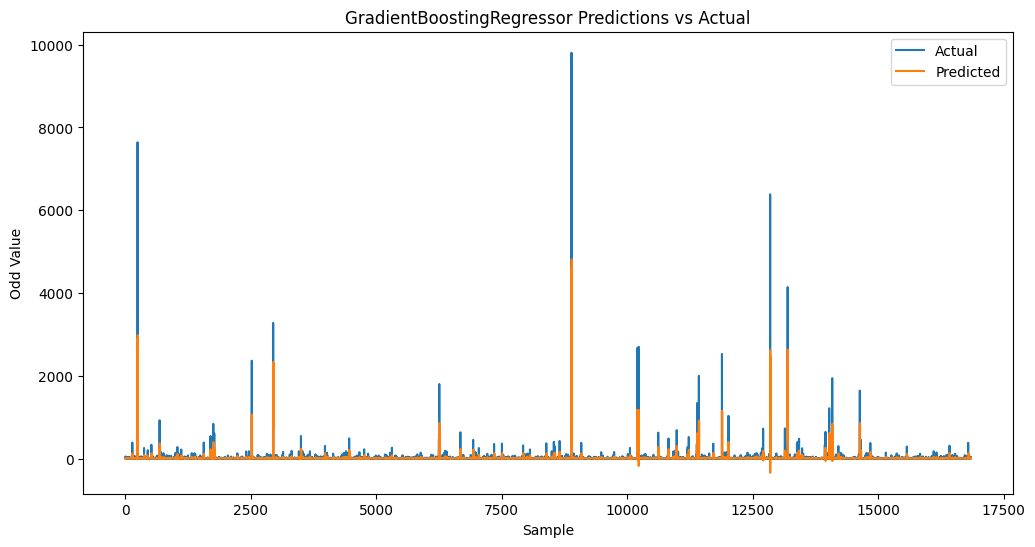

In [20]:
# Save results to CSV
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': best_model_result['predictions']
})

if best_model_result['model'] != 'ARIMA':
    future_preds = pd.DataFrame({
        'Future_Prediction': predictions
    })
    future_preds.to_csv('future_odd_predictions.csv', index=False)

results_df.to_csv('odd_prediction_results.csv', index=False)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(best_model_result['predictions'], label='Predicted')
plt.title(f"{best_model_result['model']} Predictions vs Actual")
plt.xlabel('Sample')
plt.ylabel('Odd Value')
plt.legend()
plt.savefig('predictions_vs_actual.png')
plt.show()